In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import torch_geometric as pyg
from tqdm.notebook import trange, tqdm
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.utils import from_networkx
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import os.path as osp
from torch_geometric.nn import GCNConv
from openTSNE import TSNE

## Load the data

Mouse Bio

```latex
@inproceedings{nr-aaai15,
  title = {The Network Data Repository with Interactive Graph Analytics and Visualization},
  author={Ryan A. Rossi and Nesreen K. Ahmed},
  booktitle = {Proceedings of the Twenty-Ninth AAAI Conference on Artificial Intelligence},
  url={http://networkrepository.com},
  year={2015}
}
```

In [2]:
df = pd.read_csv("./mouse_bio/bio-grid-mouse.edges", sep=",", header=None, skiprows=[0])
df.columns = ["source", "target"]

In [3]:
df

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
3267,1450,1451
3268,1451,1450
3269,1453,1279
3270,1453,1454


In [4]:
G = nx.from_pandas_edgelist(df)
data = from_networkx(G)

In [5]:
data

Data(edge_index=[2, 3272], num_nodes=1450)

In [6]:
print(f"Number of edges: {G.number_of_edges()}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Density: {nx.density(G)}")
print(f"Connected?: {nx.is_connected(G)}")
print(f"Connected components: {nx.number_connected_components(G)}")

Number of edges: 1636
Number of nodes: 1450
Density: 0.0015573165798053355
Connected?: False
Connected components: 177


## Prepare the data for the edge prediction task

In [7]:
transformer = T.Compose(
  [T.Constant(),  # Add fake feature vector
   T.AddSelfLoops(),  # Add self loop
   T.GCNNorm(),  # Symmetric normalization, averaging by n. neighbors
   T.RandomLinkSplit(num_val=0.0, is_undirected=True)  # Create train/test split for link prediction problem
  ]
)

In [8]:
train_data, _, test_data = transformer(data)

In [9]:
train_data, test_data

(Data(edge_index=[2, 4938], num_nodes=1450, x=[1450, 1], edge_weight=[4938], edge_label=[4938], edge_label_index=[2, 4938]),
 Data(edge_index=[2, 4938], num_nodes=1450, x=[1450, 1], edge_weight=[4938], edge_label=[1234], edge_label_index=[2, 1234]))

In [10]:
train_data.edge_index

tensor([[ 86, 753,  35,  ...,  32,  29, 504],
        [167, 753, 205,  ...,   7,  19, 504]])

In [11]:
test_data.edge_index

tensor([[ 86, 753,  35,  ...,  32,  29, 504],
        [167, 753, 205,  ...,   7,  19, 504]])

## GCN

[Link](https://arxiv.org/abs/1609.02907) to the offical paper. If you prefer to avoid all the math that obscures the content, check out this [blog](https://tkipf.github.io/graph-convolutional-networks/) from the same author that explains in simple words how this model works.

In essence, a GCN takes the adjacency and feature matrix and performs a multi-step convolution, where the convolution is not in the sense of "image convolution": there's no learnable parameter in the kernel; the filter is only a way to propagate the information from one node to its neighbors.

In [23]:
class GCN(torch.nn.Module):
  """Two-layer GCN."""
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)

  def forward(self, x, edge_index, edge_weight=None):
    """Forward pass.
    
    We add the dropout layer to increase the model stochasticity.
    """
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv1(x, edge_index, edge_weight).relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index, edge_weight)
    return x

  def decode(self, z, edge_label_idnex):
    """Link evaluation with edge nodes' dot-product."""
    return (
      z[edge_label_idnex[0]] * z[edge_label_idnex[1]] 
    ).sum(dim=-1)

In [14]:
model = GCN(train_data.num_features, 256, 10)

## Training

In [15]:
optimizer = torch.optim.Adam([ # model.parameters(), lr=0.01, weight_decay=5e-4)
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.01)  # Only perform weight-decay on first convolution.

In [16]:
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
for epoch in trange(1000, desc="Training", leave=False):
  model.train()
  optimizer.zero_grad()
  out = model(train_data.x, train_data.edge_index)
  prediction = model.decode(out, train_data.edge_label_index)
  loss = criterion(prediction, train_data.edge_label)
  loss.backward()
  optimizer.step()
  if epoch % 10 == 0:
    print("\rStep {}, loss {}".format(epoch, loss.item()), end="")

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step 990, loss 0.48946151137351996

In [18]:
# Test performance

model.eval()
z = model(test_data.x, test_data.edge_index)
prediction = model.decode(z, test_data.edge_label_index)
loss = criterion(prediction, test_data.edge_label)
print(loss.item())

0.6560128331184387


## Plot

In [19]:
model.eval()
z = model(data.x, data.edge_index)
z = TSNE(n_components=2).fit(z.detach().cpu().numpy())

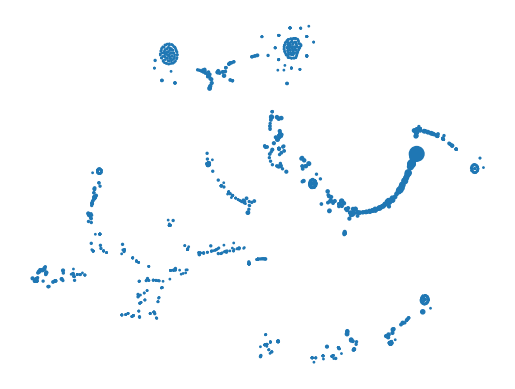

In [20]:
plt.scatter(
  z[:, 0],
  z[:, 1],
  s=[x[1] for x in G.degree]
);
plt.axis("off");
# plt.colorbar();

In [21]:
empty_model = GCN(data.num_features, 256, 10)
empty_model.eval()
z = empty_model(data.x, data.edge_index)
z = TSNE(n_components=2).fit(z.detach().cpu().numpy())

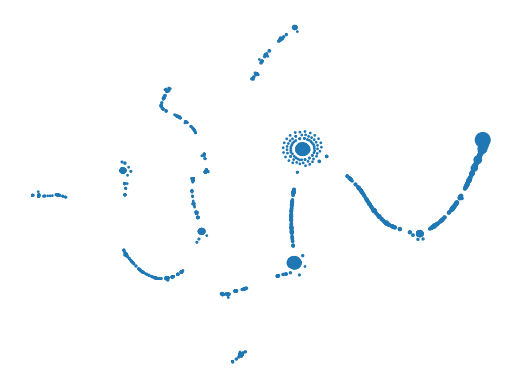

In [22]:
plt.scatter(
  z[:, 0],
  z[:, 1],
  s=[x[1] for x in G.degree]
);
plt.axis("off");
plt.title("No training!")

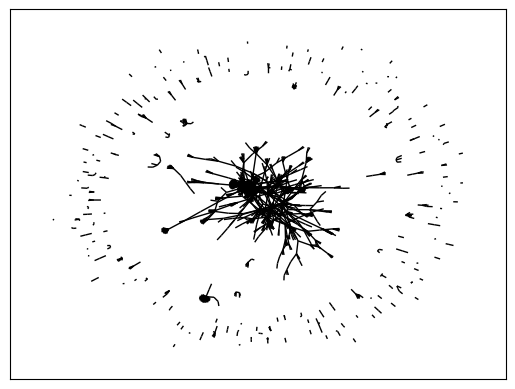

In [73]:
nx.draw_networkx_edges(G, pos=nx.spring_layout(G));

# LastFM

Recommend new artists to users. **Note** that this is an heterogenous graph.

TODO: finish writing it

In [46]:
from torch_geometric.datasets import LastFM
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv, to_hetero
from torch.nn import Linear
from torch_geometric.utils import negative_sampling

In [47]:
# @Note: this method will download the dataset from internet. This requires an internet
# connection to complete. The dataset will be cached in the provided directory.
dataset = LastFM("./Data")

In [48]:
data = dataset[0]

In [49]:
data

HeteroData(
  user={ num_nodes=1892 },
  artist={ num_nodes=17632 },
  tag={ num_nodes=1088 },
  (user, to, artist)={
    train_neg_edge_index=[2, 33294760],
    val_pos_edge_index=[2, 9283],
    val_neg_edge_index=[2, 9283],
    test_pos_edge_index=[2, 18567],
    test_neg_edge_index=[2, 18567],
    edge_index=[2, 64984]
  },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, to, user)={ edge_index=[2, 64984] },
  (artist, to, tag)={ edge_index=[2, 23253] },
  (tag, to, artist)={ edge_index=[2, 23253] }
)

In [50]:
# # Split dataset into train, val, and test set using RandomLinkSplit
# split = RandomLinkSplit(data)
# train_data = data
# val_data = data
# test_data = split

In [51]:
data

HeteroData(
  user={ num_nodes=1892 },
  artist={ num_nodes=17632 },
  tag={ num_nodes=1088 },
  (user, to, artist)={
    train_neg_edge_index=[2, 33294760],
    val_pos_edge_index=[2, 9283],
    val_neg_edge_index=[2, 9283],
    test_pos_edge_index=[2, 18567],
    test_neg_edge_index=[2, 18567],
    edge_index=[2, 64984]
  },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, to, user)={ edge_index=[2, 64984] },
  (artist, to, tag)={ edge_index=[2, 23253] },
  (tag, to, artist)={ edge_index=[2, 23253] }
)

In [52]:
# We need to add feature for each node, since the graph doesn't supply them

data['user'].x = torch.eye(data['user'].num_nodes)
# del data["user"].num_nodes
data['artist'].x = torch.eye(data['artist'].num_nodes)
# del data["artist"].num_nodes
data["tag"].x = torch.eye(data["tag"].num_nodes)
# del data["tag"].num_nodes

In [53]:
# Taken from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_link_pred.py

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # -1 dimension means check the actual size at runtime
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels, left_edge_name: str, right_edge_name: str):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
        self.left_edge_name = left_edge_name
        self.right_edge_name = right_edge_name

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat(
          [z_dict[self.left_edge_name][row],
           z_dict[self.right_edge_name][col]],
          dim=-1,
        )
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, "user", "artist")

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [153]:
# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(hidden_channels=32) #.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [154]:
# Train and evaluate model
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, data.edge_index, data.train_neg_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

def compute_loss(model, pos_edge_index, neg_edge_index):
    out = model(data.x_dict, data.edge_index_dict, pos_edge_index)
    pos_loss = -F.logsigmoid(out).mean()
    if neg_edge_index is not None:
        neg_out = model(data.x_dict, data.edge_index_dict, neg_edge_index)
        neg_loss = -F.logsigmoid(-neg_out).mean()
        return pos_loss + neg_loss
    else:
      return pos_loss

In [155]:
# Lazy evaluation of the dimension. Since we set -1 as layer dimension, the model needs to infer the actual
# shape we'll pass in.
with torch.no_grad():
    model.encoder(data.x_dict, data.edge_index_dict)

In [157]:
for i in trange(1, 10, desc="Training"):
  loss = train(model, optimizer, data["user", "to", "artist"])
  print(f"Epoch [{i:4}], loss = {loss}")

Training:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [   1], loss = 1.387261152267456
Epoch [   2], loss = 1.385124921798706
Epoch [   3], loss = 1.357254147529602
Epoch [   4], loss = 1.3116533756256104
Epoch [   5], loss = 1.237046718597412
Epoch [   6], loss = 1.1431233882904053
Epoch [   7], loss = 1.0578933954238892
Epoch [   8], loss = 0.9955927729606628
Epoch [   9], loss = 0.9819992780685425


KeyboardInterrupt: 

In [158]:
with torch.no_grad():
  val_loss = compute_loss(
    model,
    data["user", "to", "artist"].val_pos_edge_index,
    data["user", "to", "artist"].val_neg_edge_index,
  )
  print(f"Validation loss: {val_loss.item()}")

Validation loss: 0.7046891450881958


In [159]:
with torch.no_grad():
  test_loss = compute_loss(
    model,
    data["user", "to", "artist"].test_pos_edge_index,
    data["user", "to", "artist"].test_neg_edge_index,
  )
  print(f"Test loss: {test_loss.item()}")

Test loss: 0.7106888890266418


In [175]:
with torch.no_grad():
  x = model.encoder(data.x_dict, data.edge_index_dict)

In [189]:
tsne = TSNE(n_components=2, n_jobs=8)

In [191]:
%%time

user = tsne.fit(x["user"])
artist = tsne.fit(x["artist"])

CPU times: user 3min 45s, sys: 6.87 s, total: 3min 52s
Wall time: 1min 11s
